In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
import glob
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir =  "/content/drive/MyDrive/comp448-hw2/nucleus-dataset/"

#Data loading

In [5]:
tissue_img = cv2.imread(data_dir + "test_2.png")

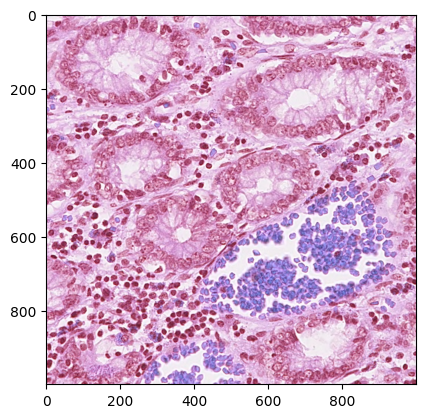

In [6]:
plt.imshow(tissue_img)

In [7]:
gray_img = cv2.cvtColor(tissue_img,cv2.COLOR_BGR2GRAY)

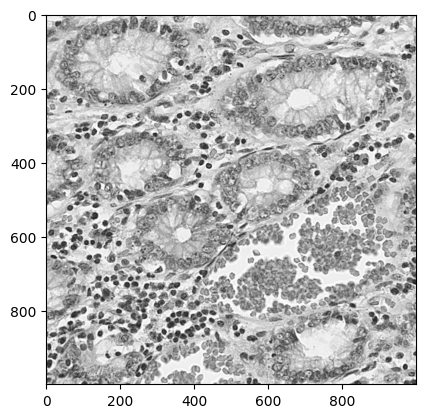

In [8]:
plt.imshow(gray_img, cmap="gray")

#Part 1

In [9]:
def compute_histogram(data, bins=10, rang=None):
    # If range is not specified, use the range of the data
    if rang is None:
        rang = (data.min(), data.max())
    
    # Compute the bin edges
    bin_edges = np.linspace(rang[0], rang[1], bins+1)
    
    # Initialize the histogram
    hist = np.zeros(bins)
    
    # Compute the histogram
    for i in range(bins):
        hist[i] = np.sum((data >= bin_edges[i]) & (data < bin_edges[i+1]))
    
    return hist, bin_edges

def calculateIntensityFeatures(patch, binNumber):
    # Calculate average and standard deviation
    avg = np.mean(patch)
    std = np.std(patch)
    
    # Calculate histogram and bin edges
    hist, bin_edges = compute_histogram(patch, binNumber, (0, 255))
    
    # Calculate bin frequencies and probabilities
    bin_frequencies = hist.astype(np.float32) / np.sum(hist)
    bin_probabilities = bin_frequencies / np.sum(bin_frequencies)
    
    # Calculate entropy
    entropy = -np.sum(bin_probabilities * np.log2(bin_probabilities + 1e-8))
    
    return avg, std, entropy

In [10]:
def lookCooccurance(mat, i, j, di, dj):
  count = 0
  for k in range(mat.shape[0]):
    for l in range(mat.shape[1]):
      #check if not out boundaried
      if k+di >= 0 and k+di<mat.shape[0] and l+dj >=0 and l+dj <mat.shape[1]:
        if mat[k][l] == i and mat[k+di][l+dj] == j:
          count+=1
          
  return count

In [11]:
def calculateCooccurrenceMatrix(patch, binNumber, di, dj):
  #first group pixels to bins
  bin_width = 256//binNumber
  grouped_img = patch // bin_width

  P = np.zeros((binNumber, binNumber))
  for i in range(binNumber):
    for j in range(binNumber):
        P[i][j] = lookCooccurance(grouped_img, i, j, di, dj)

  return P 


In [12]:
def calculateAccumulatedCooccurrenceMatrix(patch, binNumber, d):
  accM = np.zeros((binNumber, binNumber))
  for di in [-d, 0 ,d]:
    for dj in [-d, 0 ,d]:
      if dj == 0 and di == 0:
        continue
      accM+= calculateCooccurrenceMatrix(patch, binNumber, di, dj)
  return accM

In [13]:
def inverse_difference_moment(matrix):
    rows, cols = matrix.shape
    idm = 0
    for i in range(rows):
        for j in range(cols):
            idm += matrix[i, j] / (1 + (i - j) ** 2)
    return idm

def calculateCooccurrenceFeatures(accM):
    # Normalize accumulated co-occurrence matrix
    normM = accM / np.sum(accM)
    
    # Calculate texture features
    asm = np.sum(normM ** 2)
    max_prob = np.max(normM)
    idm = inverse_difference_moment(normM)
    entropy = -np.sum(normM * np.log2(normM + 1e-8))
    
    return asm, max_prob, idm, entropy

In [14]:
def calculateAllFeatures(dir, binNumber, dist, window_size=32):

  # Initialize lists to store features and labels of all cells
  all_features = []
  all_labels = []
  
  N = window_size

  files = glob.glob(dir + "/t*.png")
  for img in files:
      print(img)
      img_features = []
      name = re.search(r"(test_1|train_8|train_11|train_14|test_2|train_21)", img)
      name = name.group(1)

      cell_img = cv2.imread(img)
      gray_img = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
      annotation_file = re.split("\.", img)[0] + "_cells"


      with open(data_dir + '/' + name  + '_features_' + str(window_size) + '_' + str(binNumber) + '_' + str(dist) +'.txt', 'w') as feature_file:

        file = open(annotation_file,'r')

        # Loop through all cells in the annotation file
        for cell in file.readlines():
          cell_x, cell_y, cell_label = re.split(r'\t+', cell)
          cell_x = int(cell_x)
          cell_y = int(cell_y)
        
          # Crop patch around cell
          patch = gray_img[cell_y-N//2:cell_y+N//2, cell_x-N//2:cell_x+N//2]
      
          # Extract intensity-based features
          avg, std, entropy = calculateIntensityFeatures(patch, binNumber)
      
          # Extract textural features
          accM = calculateAccumulatedCooccurrenceMatrix(patch, binNumber, dist)
          asm, max_prob, idm, tex_entropy = calculateCooccurrenceFeatures(accM)
      
          # Concatenate features into a single vector
          features = np.concatenate((np.array([avg, std, entropy]), np.array([asm, max_prob, idm, tex_entropy])))

          all_features.append(features)
          all_labels.append(cell_label)

          feature_file.write("%s\n" %cell)
          feature_file.write("%s\n" %str(avg))
          feature_file.write("%s\n" %str(std))
          feature_file.write("%s\n" %str(entropy))
          feature_file.write("%s\n" %str(asm))
          feature_file.write("%s\n" %str(max_prob))
          feature_file.write("%s\n" %str(idm))
          feature_file.write("%s\n" %str(tex_entropy))

  return all_features

In [15]:
patch_size = 16
binNo = 5
dist = 2

In [ ]:
all_ftrs = calculateAllFeatures(data_dir, binNo, dist, patch_size)

In [17]:
def getFeatures(file_name):

  file = open(data_dir + file_name, 'r')
  line = file.readline()

  labels = []
  all_ftrs = []
  coords = []
  weights = []
  cell_count = 0

  while True:
    # Get next line from file
    temp_list = []
    cell_x, cell_y, cell_label = re.split(r'\t+', line)
    labels.append(cell_label[:-1])
    coords.append([int(cell_x), int(cell_y)])

    if cell_label[:-1] == "spindle":
      weights.append(1)    ##ratio of each cell type used as weight
    elif cell_label[:-1] == "epithelial":
      weights.append(1.33)
    elif cell_label[:-1] == "inflammation":
      weights.append(2.67)

    cell_count += 1

    line = file.readline()
    line = file.readline()
    f1 = float(line[:-1])
    temp_list.append(f1)
    line = file.readline()
    f2 = float(line[:-1])
    temp_list.append(f2)
    line = file.readline()
    f3 = float(line[:-1])
    temp_list.append(f3)
    line = file.readline()
    f4 = float(line[:-1])
    temp_list.append(f4)
    line = file.readline()
    f5 = float(line[:-1])
    temp_list.append(f5)
    line = file.readline()
    f6 = float(line[:-1])
    temp_list.append(f6)
    line = file.readline()
    f7 = float(line[:-1])
    temp_list.append(f7)
    line = file.readline()

    all_ftrs.append(temp_list)

    # if line is empty
    # end of file is reached
    if not line:
        break
 
  file.close()

  return all_ftrs, labels, coords, cell_count, weights


#Part 2 & 3

In [35]:
test_features, test_labels, test_coords, test_weights, train_features, train_labels, train_coords, train_weights  = [], [], [], [], [], [], [], []
cell_counts = {}
img_order = []

files = os.listdir(data_dir)
for f in files:
  if f[0] == "t"  and f[-3:] == "txt": #and f[-6:-4] == str(patch_size) and f[-6:-4] == str(binNo) and f[-6:-4] == str(dist)

    if f[0:5] == "train" and f[-11:-4] == "12_16_4":
    #f[-10:-4] == "16_5_2":
    #f[-11:-4] == "12_16_4":
      ftrs, labels, coords, count, weights = getFeatures(f)
      img_order.append(f)

      train_labels.extend(labels)
      train_features.extend(ftrs)
      cell_counts[f] = count
      train_coords.extend(coords)
      train_weights.extend(weights)

    elif f[0:4] == "test" and f[-11:-4] == "12_16_4":
      ftrs, labels, coords, count, weights = getFeatures(f)
      img_order.append(f)

      test_labels.extend(labels)
      test_features.extend(ftrs)
      cell_counts[f] = count
      test_coords.extend(coords)
      test_weights.extend(weights)

In [36]:
all_labels = train_labels.copy()
all_labels.extend(test_labels)
# Get count occurrence of all values
import pandas as pd
# Get all occurrences using pandas
labels = pd.Series(all_labels)
counts = labels.value_counts()
ratios = counts / counts.sum()
ratios_inverse = 1 / ratios
ratios_inverse_norm = ratios_inverse / 2.121333
ratios_inverse_norm

spindle         1.000000
epithelial      1.336899
inflammation    2.678572
dtype: float64

In [41]:
def performKMeans(features, rain_weights, test_features, test_weights, iter = 3):
  kmeans = KMeans(init="random", n_clusters=5, max_iter=iter)

  scaler = StandardScaler()
  scaled_features = scaler.fit_transform(features)

  kmeans.fit(scaled_features, sample_weight= train_weights)
  cluster_labels_test = kmeans.predict(test_features, sample_weight= test_weights)

  fte_colors = {0: "#008fd5",1: "#fc4f30", 2:"#A020F0", 3: "#20f02a", 4: "#d4f020"}

  km_colors = [fte_colors[label] for label in kmeans.labels_]
  plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=km_colors, s=2)
  print(kmeans.labels_)
  return kmeans.labels_, cluster_labels_test

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[3 1 0 ... 0 0 3]


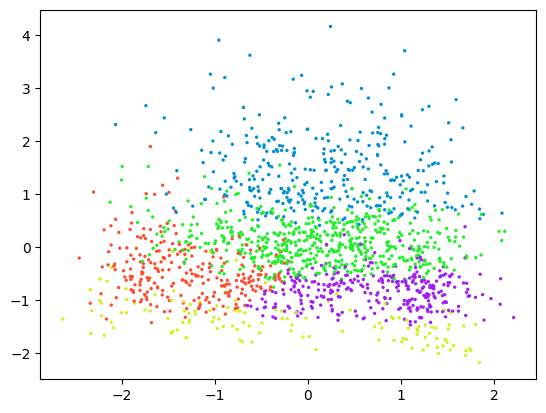

In [42]:
cluster_labels, cluster_test_labels = performKMeans(train_features, train_weights, test_features, test_weights)

In [43]:
def calc_perf(cluster_labels, truth_labels):
  cluster_0 = {'epithelial' : 0, 'spindle' : 0, 'inflammation' : 0}
  cluster_1 = {'epithelial' : 0, 'spindle' : 0, 'inflammation' : 0}
  cluster_2 = {'epithelial' : 0, 'spindle' : 0, 'inflammation' : 0}
  cluster_3 = {'epithelial' : 0, 'spindle' : 0, 'inflammation' : 0}
  cluster_4 = {'epithelial' : 0, 'spindle' : 0, 'inflammation' : 0}

  for index, label in enumerate(cluster_labels):
    if label == 0:
      cluster_0[truth_labels[index]] += 1
    elif label == 1:
      cluster_1[truth_labels[index]] += 1
    elif label == 2:
      cluster_2[truth_labels[index]] += 1
    elif label == 3:
      cluster_3[truth_labels[index]] += 1
    elif label == 4:
      cluster_4[truth_labels[index]] += 1

  total = 0
  for type in cluster_0:
    total += cluster_0[type]
  for type in cluster_0:
    if total != 0:
      cluster_0[type] = cluster_0[type]/total
  
  total = 0
  for type in cluster_1:
    total += cluster_1[type]
  for type in cluster_1:
    if total != 0:
      cluster_1[type] = cluster_1[type]/total
  
  total = 0
  for type in cluster_2:
    total += cluster_2[type]
  for type in cluster_2:
    if total != 0:
      cluster_2[type] = cluster_2[type]/total
  
  total = 0
  for type in cluster_3:
    total += cluster_3[type]
  for type in cluster_3:
    if total != 0:
      cluster_3[type] = cluster_3[type]/total

  total = 0
  for type in cluster_4:
    total += cluster_4[type]
  for type in cluster_4:
    if total != 0:
      cluster_4[type] = cluster_4[type]/total


  print("Cluster 0 -->")
  print(cluster_0)
  print("Cluster 1 -->")
  print(cluster_1)
  print("Cluster 2 -->")
  print(cluster_2)
  print("Cluster 3 -->")
  print(cluster_3)
  print("Cluster 4 -->")
  print(cluster_4)
  print()

print("Train Performance")
calc_perf(cluster_labels, train_labels)
print("Test Performance")
calc_perf(cluster_test_labels, test_labels)

Train Performance
Cluster 0 -->
{'epithelial': 0.3893805309734513, 'spindle': 0.528023598820059, 'inflammation': 0.08259587020648967}
Cluster 1 -->
{'epithelial': 0.30952380952380953, 'spindle': 0.20238095238095238, 'inflammation': 0.4880952380952381}
Cluster 2 -->
{'epithelial': 0.3247588424437299, 'spindle': 0.6752411575562701, 'inflammation': 0.0}
Cluster 3 -->
{'epithelial': 0.4493006993006993, 'spindle': 0.479020979020979, 'inflammation': 0.07167832167832168}
Cluster 4 -->
{'epithelial': 0.2734375, 'spindle': 0.5, 'inflammation': 0.2265625}

Test Performance
Cluster 0 -->
{'epithelial': 0.2018111254851229, 'spindle': 0.40620957309184996, 'inflammation': 0.39197930142302717}
Cluster 1 -->
{'epithelial': 0, 'spindle': 0, 'inflammation': 0}
Cluster 2 -->
{'epithelial': 0.44981412639405205, 'spindle': 0.5055762081784386, 'inflammation': 0.04460966542750929}
Cluster 3 -->
{'epithelial': 0, 'spindle': 0, 'inflammation': 0}
Cluster 4 -->
{'epithelial': 0, 'spindle': 0, 'inflammation': 0}

In [45]:
def save_image(img, coords1, coords2, coords3, coords4, coords5):
   plt.plot([x[0] for x in coords1], [y[1] for y in coords1], 'bo', markersize=3)
   plt.plot([x[0] for x in coords2], [y[1] for y in coords2], 'ro', markersize=3)
   plt.plot([x[0] for x in coords3], [y[1] for y in coords3], 'go', markersize=3)
   plt.plot([x[0] for x in coords4], [y[1] for y in coords4], 'yo', markersize=3)
   plt.plot([x[0] for x in coords5], [y[1] for y in coords5], 'mo', markersize=3)
   name = re.search(r"(test_1|train_8|train_11|train_14|test_2|train_21)", img)
   name = name.group(1)
   plt.imshow(cv2.imread(data_dir + name + ".png" ), cmap = "gray")
   plt.savefig(data_dir + img[:-4] + "_k5" + ".png")
   plt.clf()
   return None

test_count = 0
train_count = 0

for img in img_order:
  cell_count = cell_counts[img]
  coords0, coords1, coords2, coords3, coords4 = [], [], [], [], []

  if img[:4] == "test":
    for i in range(cell_count):
      if cluster_test_labels[test_count] == 0:
        coords0.append(test_coords[test_count])
      elif cluster_test_labels[test_count] == 1:
        coords1.append(test_coords[test_count])
      elif cluster_test_labels[test_count] == 2:
        coords2.append(test_coords[test_count])
      elif cluster_test_labels[test_count] == 3:
        coords3.append(test_coords[test_count])
      elif cluster_test_labels[test_count] == 4:
        coords4.append(test_coords[test_count])
      test_count += 1
    save_image(img, coords0, coords1, coords2, coords3, coords4)
    
  else:
    for i in range(cell_count):
      if cluster_labels[train_count] == 0:
        coords0.append(train_coords[train_count])
      elif cluster_labels[train_count] == 1:
        coords1.append(train_coords[train_count])
      elif cluster_labels[train_count] == 2:
        coords2.append(train_coords[train_count])
      elif cluster_labels[train_count] == 3:
        coords3.append(train_coords[train_count])
      elif cluster_labels[train_count] == 4:
        coords4.append(train_coords[train_count])
      train_count += 1
    save_image(img, coords0, coords1, coords2, coords3, coords4)

<Figure size 640x480 with 0 Axes>